# Insurance Cross Sell Learn to Rank Project

## 1. Initialization

### 1.1 Packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import inflection
import pickle

from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

sns.set_style('darkgrid')

### 1.2 Support Functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

## 2. Data Reading

In [3]:
data = pd.read_csv('../Data/train.csv')

In [4]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3. Data Description

### 3.1 Rename Columns

For the sake of standardization, all column will jave their name converted to a Snake Case format.

In [5]:
lower = lambda x: x.lower()
data.columns = list(map(lower,data.columns))

### 3.2 Data Dimesionality

In [6]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 381109
Number of Columns: 12


### 3.3 NaN's

In [7]:
data.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

There's no presence of NaN values on the dataset, which is a good sign.

### 3.4 Data Types

In [8]:
data['region_code'] = data['region_code'].astype('int64')
data['policy_sales_channel'] = data['policy_sales_channel'].astype('int64')

In [9]:
data.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code               int64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object

At a first glance, the original data types seems reasonable. Some transformations, like converting gender to a binary column, are desired, but will be implemented in future sections.

### 3.5 Statistical Description

To end this section, some simple statistical analysis are proposed on data. For this, numerical and categorical features will be treated separately.

In [10]:
numerical_features = ['age','annual_premium','vintage']
categorical_features = ['gender','driving_license','region_code','previously_insured','vehicle_age','policy_sales_channel','response']

For the Numerical Features some aggregated statistics are calculated for each column.

In [11]:
data[numerical_features].describe()

,age,annual_premium,vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


For the categorical features, charts of the distribution of some columns can be a great idea to obtain a first glance of the data. For this initial analysis, let's check the distributions of "Driving License","Previously Insured" and "Vehicle Age".

C:\Users\andre_\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

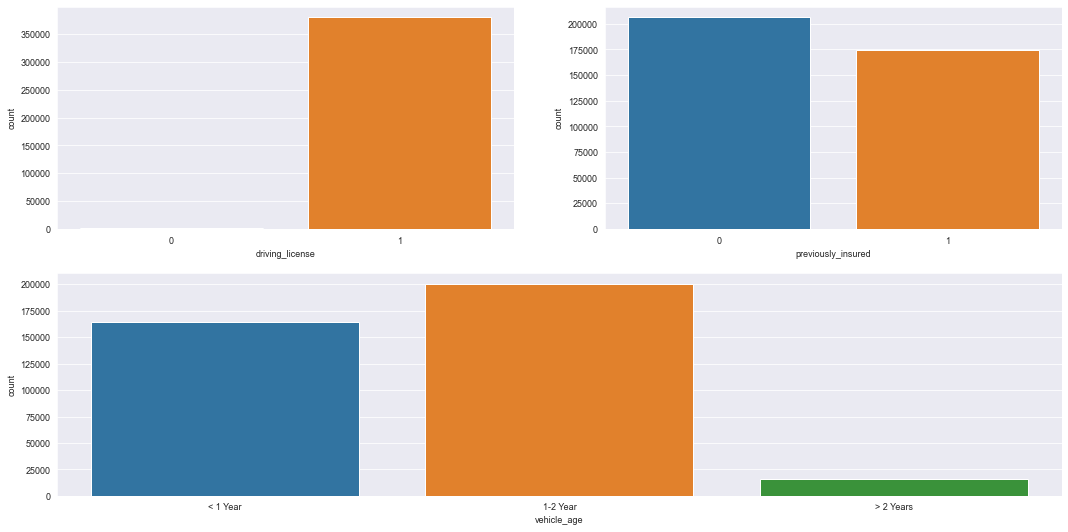

In [12]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(x='driving_license',data=data)

plt.subplot(grid[0,1])
sns.countplot(x='previously_insured',data=data)

plt.subplot(grid[1,:])
sns.countplot(data['vehicle_age'],order=['< 1 Year','1-2 Year','> 2 Years'])

The "Driving License" plot, on the upper left shows that almost all the customers on the dataset have a driving license, which is a very desired behaviour for this problem. On the upper right, "Previously Insured" presents a balanced distribution. On the lower part, the "Vehicle Age" shows that actually most of the cars of the customers are new cars, which seems to also be a desired feature for a vehicle insurance customer.

## 4. Feature Engineering

In [13]:
rule = lambda x: 1 if (x['driving_license'] == 0) & (x['vehicle_damage'] == 'Yes') else 0 
data['illegal_driver'] = data.apply(rule,axis=1)

In [14]:
rule = lambda x: 1 if (x['vehicle_damage'] == 'Yes') & (x['previously_insured'] == 0) else 0 
data['no_insured_damage'] = data.apply(rule,axis=1)

## 5. Hyphotesis Creation

To start the Hyphotesis Creation, a Mind Map containing some ideas of the main factors that influence the Target Variable. 

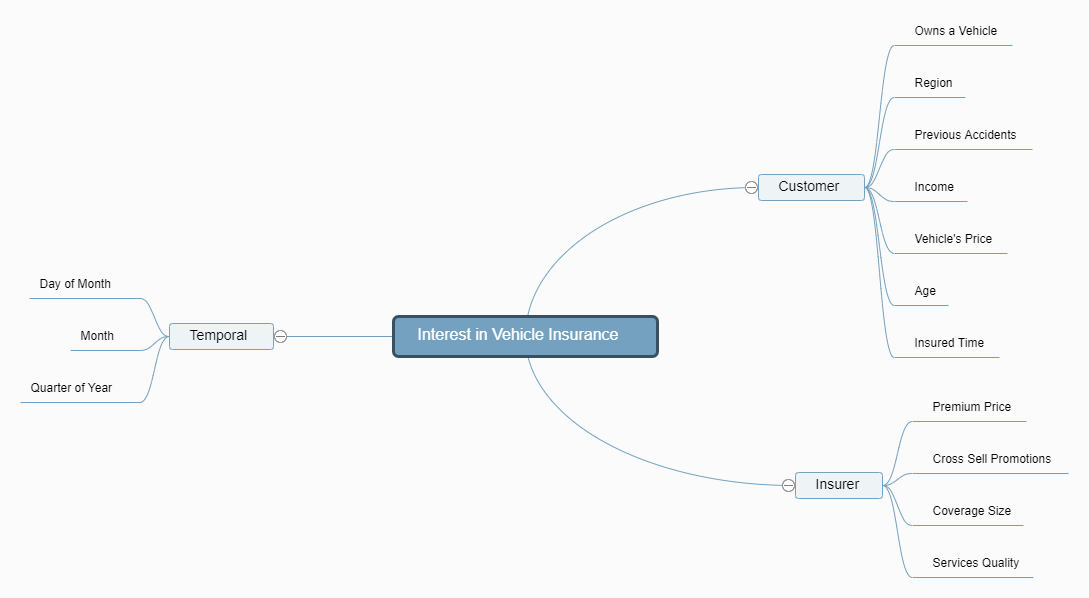

In [15]:
Image(filename='hyphotesis_map.png')

 The main factor on this map is the Customer, since it is from him that the Interest in the offered service is originated. The other two factors, actions by the Insurer and Temporal Features (which can be strongly related to vehicle sales behaviour) can increase the interest on the customers, but not create it. 

 Unfortunately, not all these factors can be studied in detail with the available data, so only hyphotesis contained in the dataset will be developed on the next steps.

  <h2> Hyphotesis List </h2>

  * Hyphotesis 1: Customers that own a vehicle should be interest in the Vehicle Insurance offer.
  * Hyphotesis 2: Customers that had their vehicles damaged in the past should be interest in the Vehicle Insurance offer.
  * Hyphotesis 3: Customers with newer vehicles should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 4: Older customers of the Health Insurance should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 5: Interest in Vehicle Insurance vary between different Regions.
  * Hyphotesis 6: Customers with cheaper Premium prices should be more interest in the Vehicle Insurance offer.

## 6. Exploratory Data Analysis (EDA)

### 6.1 Univariate Analysis

#### 6.1.1 Response Variable

<AxesSubplot:xlabel='response', ylabel='count'>

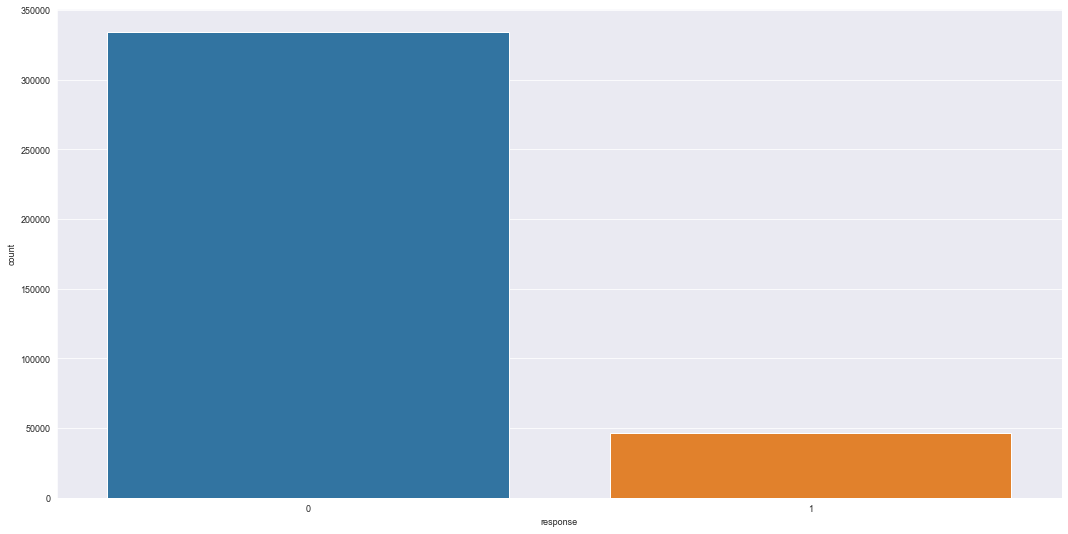

In [16]:
sns.countplot(x='response',data=data)

#### 6.1.2 Numerical Variables

In [17]:
data.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,illegal_driver,no_insured_damage
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,0,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,0,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,0,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,0,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,0,0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_premium'}>],
       [<AxesSubplot:title={'center':'vintage'}>, <AxesSubplot:>]],
      dtype=object)

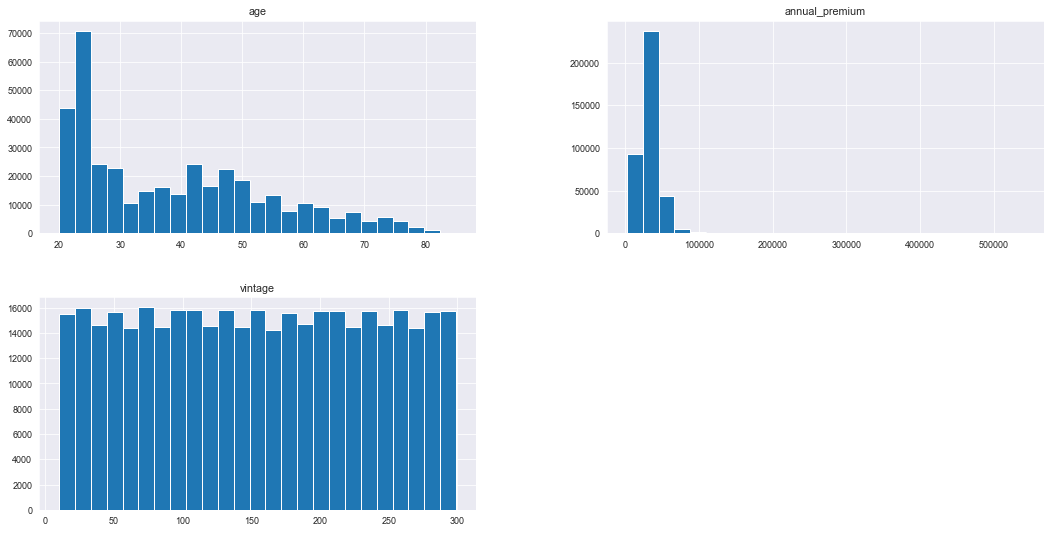

In [18]:
num_features = ['age','annual_premium','vintage']
data[num_features].hist(bins=25)

#### 6.1.3 Categorical Variables

C:\Users\andre_\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

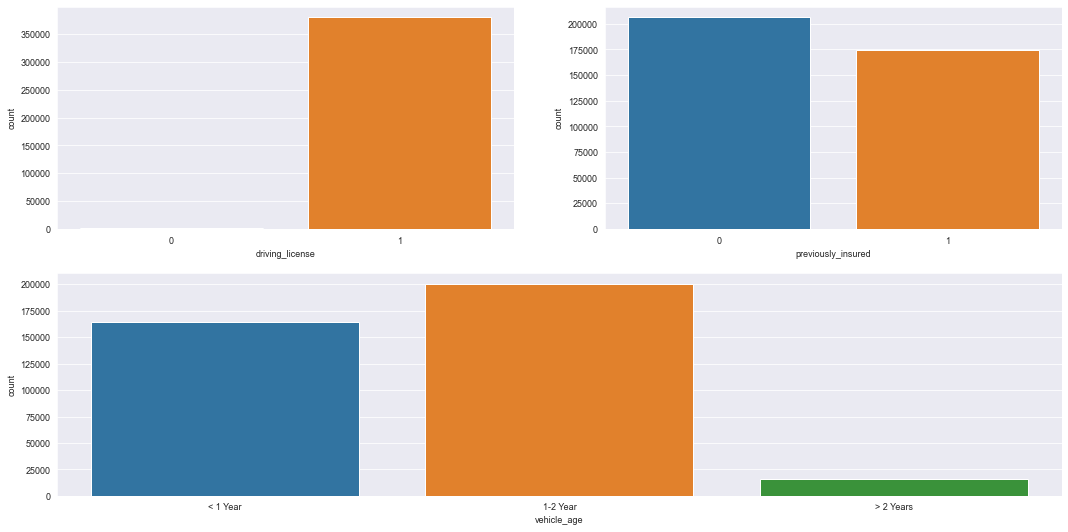

In [19]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(x='driving_license',data=data)

plt.subplot(grid[0,1])
sns.countplot(x='previously_insured',data=data)

plt.subplot(grid[1,:])
sns.countplot(data['vehicle_age'],order=['< 1 Year','1-2 Year','> 2 Years'])

### 6.2 Bivariate Analysis

  <h2> Hyphotesis List </h2>

  * Hyphotesis 1: Customers that own a vehicle should be interest in the Vehicle Insurance offer.
  * Hyphotesis 2: Customers that have their vehicles damaged in the past should be interest in the Vehicle Insurance offer.
  * Hyphotesis 3: Customers with newer vehicles should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 4: Older customers of the Health Insurance should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 5: Interest in Vehicle Insurance vary between different Regions.
  * Hyphotesis 6: Customers with cheaper Premium prices should be more interest in the Vehicle Insurance offer.

#### 6.2.1 Hyphotesis 1: Customers that own a vehicle should be interest in the Vehicle Insurance offer.

* False: Most of the customers that own a vehicle actually don't have interested in Vehicle Insurance.

<AxesSubplot:xlabel='response', ylabel='count'>

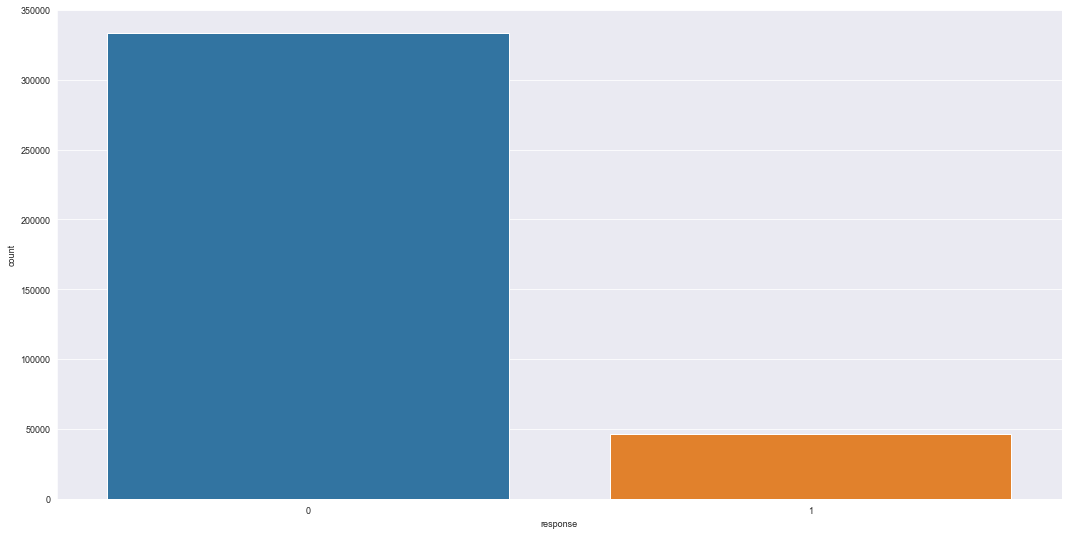

In [20]:
plot_data = data[data['driving_license']==1]
sns.countplot(x='response',data=plot_data)

#### 6.2.2 Hyphotesis 2: Customers that had their vehicles damaged in the past should be interested in the Vehicle Insurance offer.

* False: Most of the customers that had their vehicles damaged in past actually don't have interested in Vehicle Insurance.

<AxesSubplot:xlabel='response', ylabel='count'>

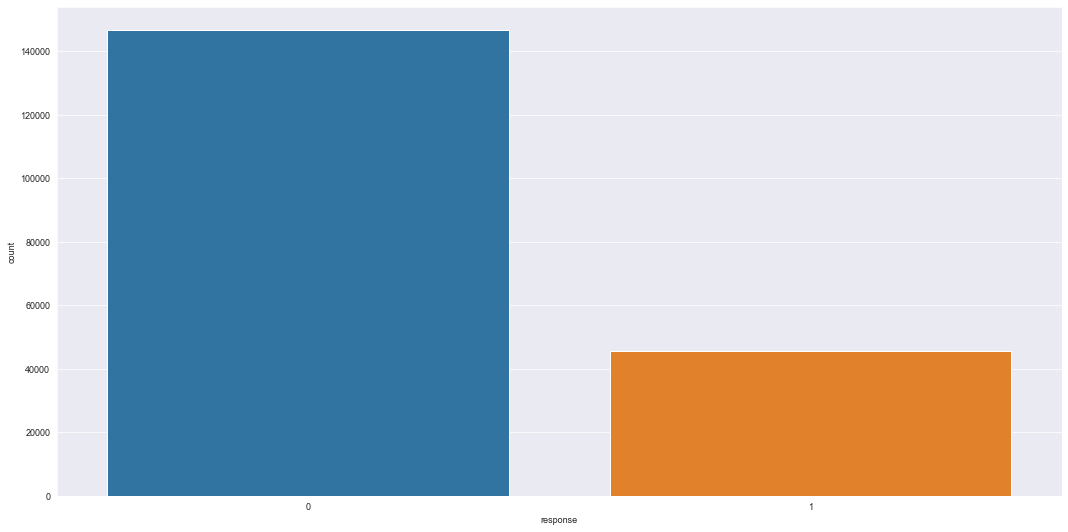

In [21]:
plot_data = data[data['vehicle_damage']=='Yes']
sns.countplot(x='response',data=plot_data)

#### 6.2.3 Hyphotesis 3: Customers with newer vehicles should be more interested in the Vehicle Insurance offer.

* False: Most of the customers that have interest in the Vehicle Insurance have vehicles with ages between 1 and 2 years.

<AxesSubplot:xlabel='vehicle_age', ylabel='id'>

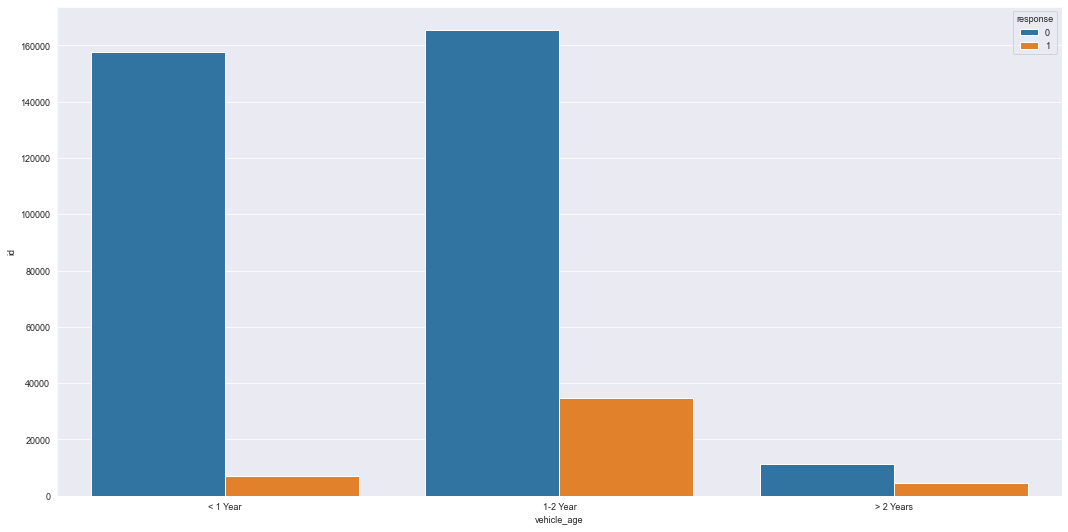

In [22]:
plot_data = data.groupby(['vehicle_age','response']).count().reset_index()
sns.barplot(x='vehicle_age',y='id',data=plot_data,hue='response',order=['< 1 Year','1-2 Year','> 2 Years'])

#### 6.2.4 Hyphotesis 4: Older customers of the Health Insurance should be more interested in the Vehicle Insurance offer.
* False: The distribution of the interested and not interested customers remains almost constant between newer and older customers.

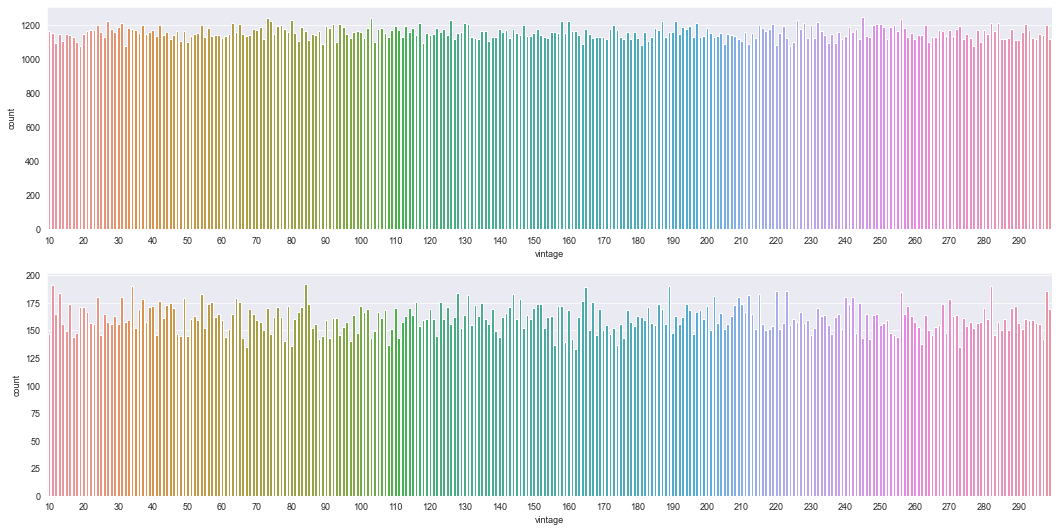

In [23]:
grid = plt.GridSpec(2,1)

plt.subplot(grid[0,0])
plot_data = data[data['response']==0]
ax = sns.countplot(x='vintage',data=plot_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.subplot(grid[1,0])
plot_data = data[data['response']==1]
ax = sns.countplot(x='vintage',data=plot_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

#### 6.2.5 Hyphotesis 5: Interest in Vehicle Insurance vary between different Regions.

* True: Different Regions have differences in customers interested in the vehicle insurance.

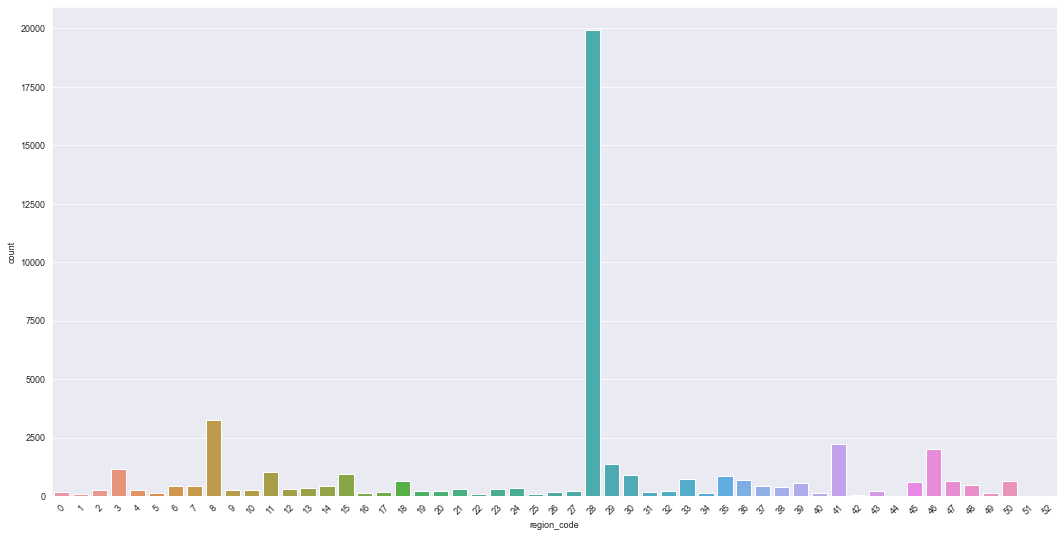

In [24]:
plot_data = data[data['response']==1]
sns.countplot(x='region_code',data=plot_data)
plt.xticks(rotation=45);

#### 6.2.6 Hyphotesis 6: Customers with cheaper Premium prices should be more interest in the Vehicle Insurance offer.

* False: Both Customers interested and not interested in Vehicle Insurance follows a similar distribution in terms of the Premium Price.

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

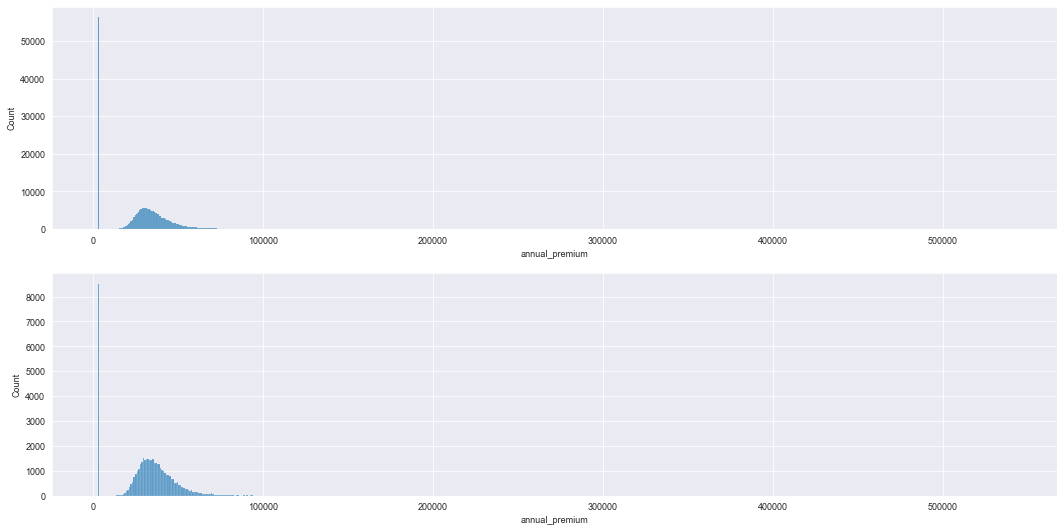

In [25]:
grid = plt.GridSpec(2,1)

plt.subplot(grid[0,0])
plot_data = data[data['response']==0]
sns.histplot(x='annual_premium',data=plot_data)

plt.subplot(grid[1,0])
plot_data = data[data['response']==1]
sns.histplot(x='annual_premium',data=plot_data)

### 6.3 Multivariate Analysis

#### 6.3.1 Numerical Variables

<AxesSubplot:>

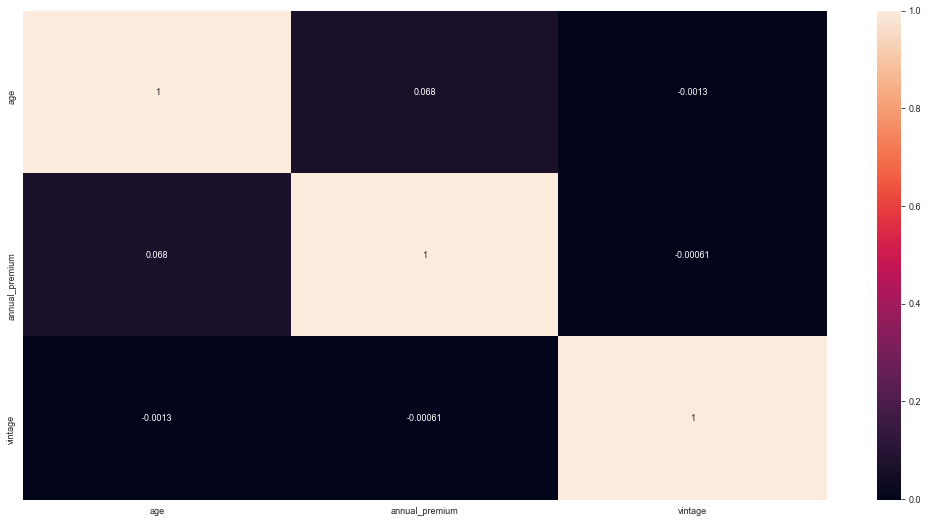

In [26]:
num_features = ['age','annual_premium','vintage']
correlation = data[num_features].corr(method = 'pearson')
sns.heatmap(correlation, annot=True)

#### 6.3.2 Categorical Variables

In [27]:
a1 = cramer_v(data['driving_license'],data['driving_license'])
a2 = cramer_v(data['driving_license'],data['previously_insured'])
a3 = cramer_v(data['driving_license'],data['vehicle_age'])

a4 = cramer_v(data['previously_insured'],data['driving_license'])
a5 = cramer_v(data['previously_insured'],data['previously_insured'])
a6 = cramer_v(data['previously_insured'],data['vehicle_age'])

a7 = cramer_v(data['vehicle_age'],data['driving_license'])
a8 = cramer_v(data['vehicle_age'],data['previously_insured'])
a9 = cramer_v(data['vehicle_age'],data['vehicle_age'])

In [28]:
correlation = pd.DataFrame({
    'driving_license' : [a1,a2,a3],
    'previously_insured' : [a4,a5,a6],
    'vehicle_age' : [a7,a8,a9]
})

correlation = correlation.set_index(correlation.columns)

<AxesSubplot:>

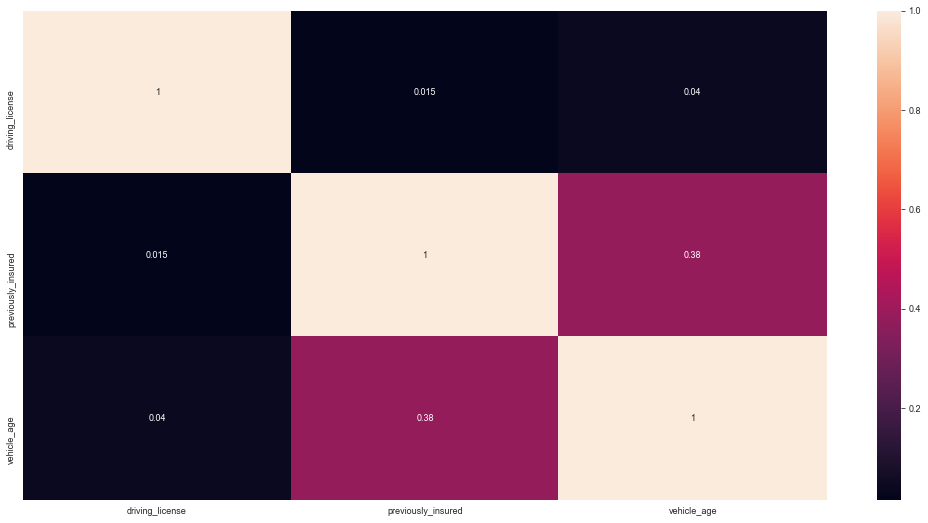

In [29]:
sns.heatmap(correlation,annot=True)

## 7. Data Preparation

### 7.1 Transformations

In [30]:
gender_dict = {'Male' : 0, 'Female' : 1}
data['gender'] = data['gender'].map(gender_dict)

In [31]:
vehicle_damage_dict = {'No' : 0, 'Yes' : 1}
data['vehicle_damage'] = data['vehicle_damage'].map(vehicle_damage_dict)

In [32]:
data = pd.get_dummies(data,prefix=['vehicle_age'],columns=['vehicle_age'])

In [33]:
data.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,illegal_driver,no_insured_damage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
0,1,0,44,1,28,0,1,40454.0,26,217,1,0,1,0,0,1
1,2,0,76,1,3,0,0,33536.0,26,183,0,0,0,1,0,0
2,3,0,47,1,28,0,1,38294.0,26,27,1,0,1,0,0,1
3,4,0,21,1,11,1,0,28619.0,152,203,0,0,0,0,1,0
4,5,1,29,1,41,1,0,27496.0,152,39,0,0,0,0,1,0


### 7.2 Train-Test Split

In [34]:
X = data.drop('response',axis=1)
y = data['response']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

### 7.3 Standardization

No Numerical Feature presented a Normal Distribution, so  Standardization processes were not needed.

### 7.4 Rescaling

In [36]:
rs = RobustScaler()

X_train['annual_premium'] = rs.fit_transform(X_train[['annual_premium']].values)
X_test['annual_premium'] = rs.transform(X_test[['annual_premium']].values)
pickle.dump(rs,open('../Parameters/annual_premium_scaler.pkl','wb'))

C:\Users\andre_\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\andre_\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [37]:
mms = MinMaxScaler()


X_train['age'] = rs.fit_transform(X_train[['age']].values)
X_test['age'] = rs.transform(X_test[['age']].values)
pickle.dump(rs,open('../Parameters/age_scaler.pkl','wb'))

X_train['vintage'] = rs.fit_transform(X_train[['vintage']].values)
X_test['vintage'] = rs.transform(X_test[['vintage']].values)
pickle.dump(rs,open('../Parameters/vintage_scaler.pkl','wb'))

C:\Users\andre_\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\andre_\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\andre_\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

### 7.5 Feature Selection

In [38]:
X_train_values = X_train.values
y_train_values = y_train.values.ravel()

In [39]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [56]:
feature_importance = rf.feature_importances_

In [57]:
feature_importance = pd.DataFrame([X_train.columns,feature_importance]).T
feature_importance.columns = ['columns','feature_importance']
feature_importance = feature_importance.sort_values('feature_importance',ascending=False)

<AxesSubplot:xlabel='feature_importance', ylabel='columns'>

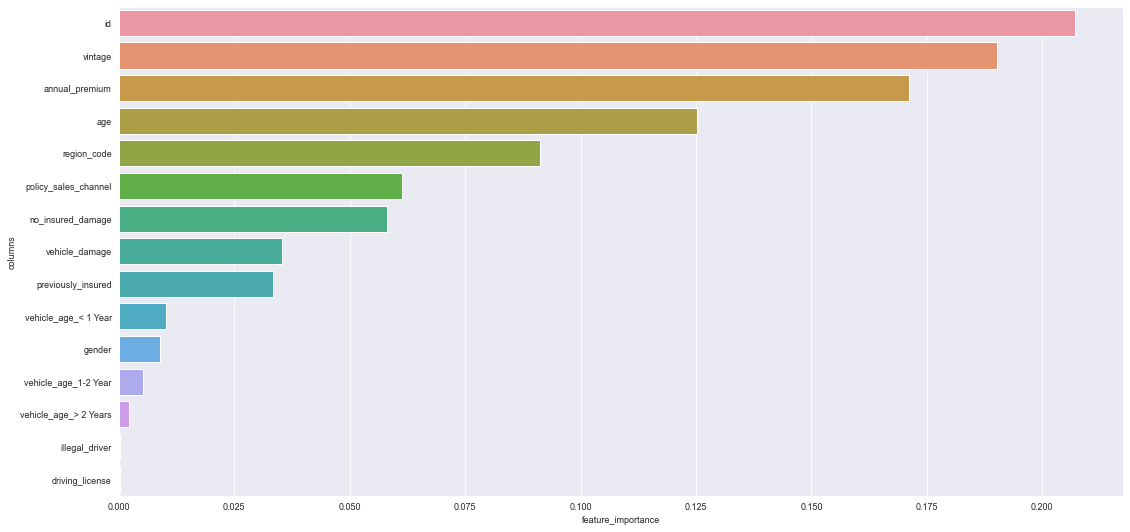

In [60]:
sns.barplot(y='columns',x='feature_importance',data=feature_importance,orient='h')

In [61]:
selected_columns = ['id','vintage','annual_premium','age','region_code']
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]